# Problem

**10×10 Gridworld**

**Layout (row-major indices)**

Legend: **S** start, **G** goal (terminal), **P** pit (terminal), **#** wall, **.** empty

```
r\c  0 1 2 3 4 5 6 7 8 9
0    S . . . # . . . . .
1    . # . . # . . # P .
2    . # # . . . . # . .
3    . . P . # . . # . .
4    # . # # # # # # . #
5    . . . . # . . P . .
6    . P # . # . # . . .
7    . . # . . P # . . .
8    . . # . # . # # . .
9    . . . . # . . . . G
```

**State space**

$$
\mathcal{X}={0,1,\dots,99},\quad x=10r+c
$$

* **Goal (absorbing):** $x_G=99$
* **Pits (absorbing):**
  $
  \mathcal{X}_{\text{pit}}={18,32,57,61,75,88}
  $
* **Walls (impassable):**
  $
  \mathcal{X}_{\text{wall}}={4,11,14,17,21,22,27,34,37,40,42,43,44,45,46,47,49,54,62,64,66,72,76,82,84,86,87,94}
  $

Terminal set:
$
\mathcal{T}={99}\cup \mathcal{X}_{\text{pit}}
$

**Action space**

$$
\mathcal{A}={0,1,2,3}
$$
where (0=) Up, (1=) Down, (2=) Left, (3=) Right.

**Transition dynamics (deterministic)**

Let $x\mapsto(r,c)$ by $r=\lfloor x/10\rfloor,\ c=x\bmod 10$.

* If $x\in\mathcal{T}$, then $\text{next\_state}(x,a)=x$ $absorbing$.
* Otherwise, compute the intended neighbor $(r',c')$ from action $a$.
* If $(r',c')$ is outside the grid, **stay**.
* Let $x'=10r'+c'$. If $x'\in\mathcal{X}_{\text{wall}}$, **stay**.

Transition matrix shape:
$$
P\in\mathbb{R}^{(|\mathcal{X}||\mathcal{A}|)\times|\mathcal{X}|}=\mathbb{R}^{400\times 100},
$$
with
$$
P[(x,a),x']=1 \iff x'=\text{next\_state}(x,a)
$$

**Reward model (standard step cost + terminal outcomes)**

Reward based on the **next state**:
$$
r(x,a)=
\begin{cases}
+1 & \text{if } \text{next\_state}(x,a)=99,\
-5 & \text{if } \text{next\_state}(x,a)\in \mathcal{X}_{\text{pit}},\
-0.1 & \text{otherwise.}
\end{cases}
$$

**Initial state**

$$
x_0=0.
$$

In [21]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import random
import torch
import pandas as pd
import sys
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

# This starts from the current working directory
# and goes up until it finds the 'fogas_torch' folder or '.git'
def find_root(current_path, marker="fogas_torch"):
    current_path = Path(current_path).resolve()
    for parent in [current_path] + list(current_path.parents):
        if (parent / marker).exists():
            return parent
    return current_path

PROJECT_ROOT = find_root(Path.cwd())
print(f"Project root found at: {PROJECT_ROOT}")
# Now define the dataset path
DATASET_PATH = PROJECT_ROOT / "datasets" / "10grid_wall.csv"
print(f"Loading dataset from: {DATASET_PATH}")

from fogas_torch import PolicySolver, EnvDataCollector
from fogas_torch.algorithm import (
    FOGASSolverVectorized,
    FOGASOracleSolverVectorized,
    FOGASHyperOptimizer,
    FOGASEvaluator,
)
from fogas.dataset_collection.dataset_analyzer import DatasetAnalyzer
from fogas_torch.fqi.fqi_solver import FQISolver
from fogas_torch.fqi.fqi_evaluator import FQIEvaluator

seed = 42
np.random.seed(seed) # Add this
random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Project root found at: /shared/home/mauro.diaz/work/FOGAS
Loading dataset from: /shared/home/mauro.diaz/work/FOGAS/datasets/10grid_wall.csv
Using device: cuda


# Tabular Features

In [2]:
# ===== 10x10 Four-Rooms Grid =====

states  = torch.arange(100, dtype=torch.int64)
actions = torch.arange(4, dtype=torch.int64)
N = len(states)     # 100
A = len(actions)    # 4
gamma = 0.9

x_0 = 0  # fixed initial state

goal = 99  # absorbing terminal state

# pits (absorbing terminal states)
pits = {18, 32, 57, 61, 75}

# walls (impassable)
walls = {
    4, 11, 14, 17, 21, 22, 27, 34, 37,
    40, 42, 43, 44, 45, 46, 47, 49,
    54, 62, 64, 66, 72, 76, 82, 84, 86, 87, 94
}

# ---------- Tabular features ----------
def phi(x, a):
    vec = torch.zeros(N * A, dtype=torch.float64)
    vec[int(x) * A + int(a)] = 1.0
    return vec

# ---------- Reward weights (tabular) ----------
step_cost = -0.1
goal_reward = 1.0
pit_reward  = -5.0

omega = torch.full((N * A,), step_cost, dtype=torch.float64)

# override terminal rewards (all actions in terminal states)
omega[goal * A : goal * A + A] = goal_reward
for p in pits:
    omega[p * A : p * A + A] = pit_reward

# ---------- Helpers: index <-> (row, col) ----------
def to_rc(s):  return divmod(s, 10)
def to_s(r, c): return r * 10 + c

# ---------- Dynamics ----------
def next_state(s, a):
    # absorbing terminals
    if s == goal or s in pits:
        return s

    r, c = to_rc(s)

    if a == 0:      # Up
        r2, c2 = max(0, r - 1), c
    elif a == 1:    # Down
        r2, c2 = min(9, r + 1), c
    elif a == 2:    # Left
        r2, c2 = r, max(0, c - 1)
    elif a == 3:    # Right
        r2, c2 = r, min(9, c + 1)
    else:
        raise ValueError("Invalid action")

    sp = to_s(r2, c2)

    # wall blocks transition
    if sp in walls:
        return s

    return sp

# ---------- Backward feature map psi(x') ----------
def psi(xp):
    v = torch.zeros(N * A, dtype=torch.float64)
    for x in states:
        for a in actions:
            if next_state(int(x), int(a)) == xp:
                v[int(x) * A + int(a)] = 1.0
    return v

# ---------- Build solver ----------
mdp = PolicySolver(
    states=states,
    actions=actions,
    phi=phi,
    omega=omega,
    gamma=gamma,
    x0=x_0,
    psi=psi
)


## Oracle

In [19]:
solver = FOGASOracleSolverVectorized(
    mdp=mdp, 
    cov_matrix="identity", 
    print_params=True, 
    T=1000,
    device=device,
    seed=seed
)
evaluator = FOGASEvaluator(solver)
optimizer = FOGASHyperOptimizer(solver=solver,metric_callable=evaluator.get_metric("reward"), seed=seed)



================ FOGAS PARAMETER SUMMARY ================

Basic Information
-----------------
Dataset size n:           10000000.0
Feature norm bound R:     1.0000
Num states N:             100
Num actions A:            4
Feature dim d:            400
Discount γ:               0.9
Confidence δ:             0.05

Theoretical Quantities
----------------------
T_min (theoretical):      9255128.526390366
T (iterations):                1000   (overridden → 1000)

FOGAS Hyperparameters
---------------------
alpha:                        0.000263
rho:                            66.292053
eta:                            0.000002
D_theta:                    63.245553
beta (ridge):             0.000003
D_pi (derived):           16.651092




We do an hyperparameter optimization because is not clear how will work the Oracle in a big dimensional problem.


=== FOGAS Hyperparameter Optimization ===
[Theory] metric = 0.3761
Order: ('alpha', 'rho', 'eta')

Optimizing alpha
[After alpha*] alpha=4.7512e+00, rho=1.0000e-02, eta=1.5215e-06 | metric = 0.1000

Optimizing rho
[After rho*] alpha=4.7512e+00, rho=1.0000e-02, eta=1.5215e-06 | metric = 0.1000

Optimizing eta
[After eta*] alpha=4.7512e+00, rho=1.0000e-02, eta=3.0000e+00 | metric = 0.0432


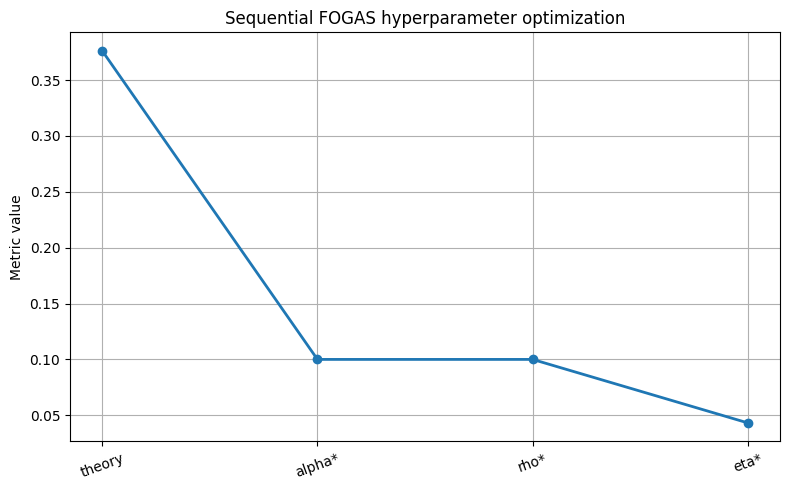

In [20]:
summary = optimizer.optimize_fogas_hyperparameters(
    search_method="random",
    coarse_points=7,
    print_main=True, 
    num_runs=1,
    random_candidates=10,
    order=("alpha", "rho", "eta"),
    bounds_overrides={"alpha" : (1e-2, 5.0), "rho" : (1e-2, 3.0), "eta" : (1e-2, 3.0)}
)

alpha_star = summary["alpha"]
rho_star = summary["rho"]
eta_star = summary["eta"]

In [21]:
solver.run(T = 10000, alpha=alpha_star, eta=eta_star, rho=rho_star, tqdm_print=True)
evaluator.print_policy()

FOGAS Oracle: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:54<00:00, 185.08it/s]

  State 0: π(a=0|s=0) = 0.00  π(a=1|s=0) = 0.41  π(a=2|s=0) = 0.00  π(a=3|s=0) = 0.59  --> best action: 3
  State 1: π(a=0|s=1) = 0.00  π(a=1|s=1) = 0.00  π(a=2|s=1) = 0.00  π(a=3|s=1) = 1.00  --> best action: 3
  State 2: π(a=0|s=2) = 0.00  π(a=1|s=2) = 0.50  π(a=2|s=2) = 0.00  π(a=3|s=2) = 0.50  --> best action: 1
  State 3: π(a=0|s=3) = 0.00  π(a=1|s=3) = 1.00  π(a=2|s=3) = 0.00  π(a=3|s=3) = 0.00  --> best action: 1
  State 4: π(a=0|s=4) = 0.00  π(a=1|s=4) = 0.00  π(a=2|s=4) = 0.00  π(a=3|s=4) = 1.00  --> best action: 3
  State 5: π(a=0|s=5) = 0.00  π(a=1|s=5) = 0.00  π(a=2|s=5) = 0.00  π(a=3|s=5) = 1.00  --> best action: 3
  State 6: π(a=0|s=6) = 0.00  π(a=1|s=6) = 0.00  π(a=2|s=6) = 0.00  π(a=3|s=6) = 1.00  --> best action: 3
  State 7: π(a=0|s=7) = 0.00  π(a=1|s=7) = 0.00  π(a=2|s=7) = 0.00  π(a=3|s=7) = 1.00  --> best action: 3
  State 8: π(a=0|s=8) = 0.00  π(a=1|s=8) = 0.00  π(a=2|s=8) = 0.00  π(a=3|s=8) = 1.00  --> best action: 3
  State 9: π(a=0|s=9) = 0.00  π(a=1|s=9) = 1.0

Let's do an easy check that the policy achieves the goal in a optimal way:

In [22]:
evaluator.print_optimal_path(goal_state=99)


  OPTIMAL PATH VISUALIZATION - Learned Policy (π_FOGAS)

Initial State: 0
Goal State: 99
Discount Factor (γ): 0.9

----------------------------------------------------------------------

  Step   0 │ State: 0        │ Action: 3       │ Reward:  -0.100 │ → 1
  Step   1 │ State: 1        │ Action: 3       │ Reward:  -0.100 │ → 2
  Step   2 │ State: 2        │ Action: 1       │ Reward:  -0.100 │ → 12
  Step   3 │ State: 12       │ Action: 3       │ Reward:  -0.100 │ → 13
  Step   4 │ State: 13       │ Action: 1       │ Reward:  -0.100 │ → 23
  Step   5 │ State: 23       │ Action: 3       │ Reward:  -0.100 │ → 24
  Step   6 │ State: 24       │ Action: 3       │ Reward:  -0.100 │ → 25
  Step   7 │ State: 25       │ Action: 0       │ Reward:  -0.100 │ → 15
  Step   8 │ State: 15       │ Action: 0       │ Reward:  -0.100 │ → 5
  Step   9 │ State: 5        │ Action: 3       │ Reward:  -0.100 │ → 6
  Step  10 │ State: 6        │ Action: 3       │ Reward:  -0.100 │ → 7
  Step  11 │ State: 7    

## Empirical

### Dataset Collection

In [13]:
# Initialize the collector with these options
collector = EnvDataCollector(
    mdp=mdp,
    env_name="10grid_wall",
    reset_probs={'custom': 1.0},
    max_steps=50,
    seed=seed
)

In [ ]:
# Create an epsilon-greedy pi_star (30% optimal, 70% random)
epsilon_policy = (mdp.pi_star, 0.3)

# Use it in your mixed collection as before
collector.collect_mixed_dataset(
    policies=[epsilon_policy, "random"],  
    proportions=[0.8, 0.2],
    n_steps=8000,
    episode_based=True,                   
    save_path=str(DATASET_PATH),
    verbose=True
)


  MIXED DATASET COLLECTION SUMMARY (TORCH)
Total transitions: 8000
Total episodes: 242
Mode: Episode-based

Policy Distribution:
  Policy 0:  6047 steps (75.6%) | Target: 80.0% | Episodes: 194
  Policy 1:  1953 steps (24.4%) | Target: 20.0% | Episodes: 49

✅ Mixed dataset saved to: /shared/home/mauro.diaz/work/FOGAS/datasets/10grid_wall.csv


,episode,step,state,action,reward,next_state,policy_id
0,0,0,0,0,-0.1,0,0
1,0,1,0,3,-0.1,1,0
2,0,2,1,3,-0.1,2,0
3,0,3,2,1,-0.1,12,0
4,0,4,12,3,-0.1,13,0
...,...,...,...,...,...,...,...
7995,242,9,3,3,-0.1,3,1
7996,242,10,3,2,-0.1,2,1
7997,242,11,2,0,-0.1,2,1
7998,242,12,2,0,-0.1,2,1


In [8]:
analyzer = DatasetAnalyzer(DATASET_PATH)

analyzer.summary()

Dataset Analysis Summary
Source: /shared/home/mauro.diaz/work/datasets/10grid_wall.csv
Total transitions: 20,000
Unique (state, action) pairs: 157
Unique states visited: 41
Unique actions taken: 4
--------------------------------------------------
Pair Frequency Statistics:
  Min count:    2
  Max count:    709
  Mean count:   127.39
  Std count:    206.35
  Median count: 56.0


### Solving it

In [5]:
solver_e = FOGASSolverVectorized(
    mdp=mdp,
    csv_path=str(DATASET_PATH),
    device=device,
    seed=seed)
evaluator_e = FOGASEvaluator(solver_e)
optimizer_e = FOGASHyperOptimizer(solver=solver_e,metric_callable=evaluator_e.get_metric("reward"), seed=seed)

In [6]:
# Run solver with best alpha and fixed rho, eta
solver_e.run(alpha=0.001 / 2, eta=0.0002, rho=0.05, tqdm_print=True, T=12000)
evaluator_e.print_policy()

FOGAS: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 12000/12000 [00:17<00:00, 679.86it/s]


  State 0: π(a=0|s=0) = 0.13  π(a=1|s=0) = 0.17  π(a=2|s=0) = 0.12  π(a=3|s=0) = 0.58  --> best action: 3
  State 1: π(a=0|s=1) = 0.13  π(a=1|s=1) = 0.14  π(a=2|s=1) = 0.05  π(a=3|s=1) = 0.68  --> best action: 3
  State 2: π(a=0|s=2) = 0.14  π(a=1|s=2) = 0.63  π(a=2|s=2) = 0.06  π(a=3|s=2) = 0.18  --> best action: 1
  State 3: π(a=0|s=3) = 0.25  π(a=1|s=3) = 0.46  π(a=2|s=3) = 0.09  π(a=3|s=3) = 0.20  --> best action: 1
  State 4: π(a=0|s=4) = 0.25  π(a=1|s=4) = 0.25  π(a=2|s=4) = 0.25  π(a=3|s=4) = 0.25  --> best action: 0
  State 5: π(a=0|s=5) = 0.15  π(a=1|s=5) = 0.07  π(a=2|s=5) = 0.13  π(a=3|s=5) = 0.65  --> best action: 3
  State 6: π(a=0|s=6) = 0.11  π(a=1|s=6) = 0.07  π(a=2|s=6) = 0.07  π(a=3|s=6) = 0.75  --> best action: 3
  State 7: π(a=0|s=7) = 0.13  π(a=1|s=7) = 0.09  π(a=2|s=7) = 0.06  π(a=3|s=7) = 0.73  --> best action: 3
  State 8: π(a=0|s=8) = 0.11  π(a=1|s=8) = 0.03  π(a=2|s=8) = 0.05  π(a=3|s=8) = 0.81  --> best action: 3
  State 9: π(a=0|s=9) = 0.10  π(a=1|s=9) = 0.7

In [7]:
evaluator_e.print_optimal_path(goal_state=99)


  OPTIMAL PATH VISUALIZATION - Learned Policy (π_FOGAS)

Initial State: 0
Goal State: 99
Discount Factor (γ): 0.9

----------------------------------------------------------------------

  Step   0 │ State: 0        │ Action: 3       │ Reward:  -0.100 │ → 1
  Step   1 │ State: 1        │ Action: 3       │ Reward:  -0.100 │ → 2
  Step   2 │ State: 2        │ Action: 1       │ Reward:  -0.100 │ → 12
  Step   3 │ State: 12       │ Action: 3       │ Reward:  -0.100 │ → 13
  Step   4 │ State: 13       │ Action: 1       │ Reward:  -0.100 │ → 23
  Step   5 │ State: 23       │ Action: 3       │ Reward:  -0.100 │ → 24
  Step   6 │ State: 24       │ Action: 3       │ Reward:  -0.100 │ → 25
  Step   7 │ State: 25       │ Action: 0       │ Reward:  -0.100 │ → 15
  Step   8 │ State: 15       │ Action: 3       │ Reward:  -0.100 │ → 16
  Step   9 │ State: 16       │ Action: 0       │ Reward:  -0.100 │ → 6
  Step  10 │ State: 6        │ Action: 3       │ Reward:  -0.100 │ → 7
  Step  11 │ State: 7   

**Stabilizing the algorithm:** After data analysis, the dataset doesnt reach a lot of states so covariance inverse is unstable. Augmenting $\beta$ helps.

- More $\beta$ = more bias / less sensitivity to uncovered directions.

- If the uncovered directions actually matter for optimality, too-large $\beta$ can make the algorithm look stable while converging to a worse solution.

In this case, we can see that $β$ = 0.0001 is a good choice.

In [11]:
solver_e1 = FOGASSolverVectorized(
    mdp=mdp,
    csv_path=str(DATASET_PATH),
    device=device,
    beta=1e-4,
    seed=seed)
evaluator_e1 = FOGASEvaluator(solver_e1)
optimizer_e1 = FOGASHyperOptimizer(solver=solver_e1,metric_callable=evaluator_e1.get_metric("reward"), seed=seed)
# Run solver with best alpha and fixed rho, eta
solver_e1.run(alpha=0.001, eta=0.0002, rho=0.05, tqdm_print=True, T=12000)
evaluator_e1.print_policy()
evaluator_e1.print_optimal_path(goal_state=99)

FOGAS: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 12000/12000 [00:51<00:00, 233.26it/s]

  State 0: π(a=0|s=0) = 0.05  π(a=1|s=0) = 0.08  π(a=2|s=0) = 0.05  π(a=3|s=0) = 0.81  --> best action: 3
  State 1: π(a=0|s=1) = 0.07  π(a=1|s=1) = 0.07  π(a=2|s=1) = 0.02  π(a=3|s=1) = 0.84  --> best action: 3
  State 2: π(a=0|s=2) = 0.05  π(a=1|s=2) = 0.80  π(a=2|s=2) = 0.02  π(a=3|s=2) = 0.13  --> best action: 1
  State 3: π(a=0|s=3) = 0.12  π(a=1|s=3) = 0.67  π(a=2|s=3) = 0.07  π(a=3|s=3) = 0.14  --> best action: 1
  State 4: π(a=0|s=4) = 0.25  π(a=1|s=4) = 0.25  π(a=2|s=4) = 0.25  π(a=3|s=4) = 0.25  --> best action: 0
  State 5: π(a=0|s=5) = 0.17  π(a=1|s=5) = 0.10  π(a=2|s=5) = 0.17  π(a=3|s=5) = 0.56  --> best action: 3
  State 6: π(a=0|s=6) = 0.10  π(a=1|s=6) = 0.06  π(a=2|s=6) = 0.06  π(a=3|s=6) = 0.78  --> best action: 3
  State 7: π(a=0|s=7) = 0.11  π(a=1|s=7) = 0.10  π(a=2|s=7) = 0.05  π(a=3|s=7) = 0.74  --> best action: 3
  State 8: π(a=0|s=8) = 0.08  π(a=1|s=8) = 0.00  π(a=2|s=8) = 0.07  π(a=3|s=8) = 0.85  --> best action: 3
  State 9: π(a=0|s=9) = 0.10  π(a=1|s=9) = 0.7

## Data Analysis

**What “alignment-based coverage” looks like in this tabular case**

FOGAS’ key coverage term is the **feature coverage ratio**
$$
|\lambda_{\pi^*}|_{\Lambda_n^{-1}}^2
$$
(and this measures how well the dataset covers the comparator policy in feature space). 

With one-hot features, the empirical covariance
$$
\Lambda_n = \beta I + \frac{1}{n}\sum_{i=1}^n \phi_i\phi_i^\top
$$
is **diagonal**, and each diagonal entry corresponds to a particular $(x,a)$:
$$
(\Lambda_n)_{(x,a),(x,a)} = \beta + \frac{N(x,a)}{n}.
$$
(Here $N(x,a)$ is how often $(x,a)$ appears in the dataset.) 

Because it’s diagonal, the coverage ratio becomes:
$$
|\lambda_{\pi^*}|_{\Lambda_n^{-1}}^2 =
\sum_{x,a}\frac{\mu_{\pi^*}(x,a)^2}{\beta + N(x,a)/n}.
$$

So **alignment-based coverage** (in tabular) literally means:

- The dataset counts $N(x,a)$ are large exactly on the $(x,a)$ where $\mu_{\pi^*}(x,a)$ is large.


In [ ]:
analyzer = DatasetAnalyzer(DATASET_PATH)

ratio = analyzer.feature_coverage_ratio(
    mdp=mdp,
    beta=1e-4,
    use_optimal_policy=True,
    verbose=True,
    return_details=True,
)


Feature Coverage Ratio Details
------------------------------
  Dataset size (n):         20000
  MDP dims (N, A, d):        (100, 4, 400)
  gamma:                    0.9
  beta (ridge):             0.0001
  policy source:            provided

  Occupancy μ_pi summary:
    sum:                    1
    min / max:              0 / 0.1

  Feature occupancy λ_pi summary:
    ||λ||_2:                0.242197
    ||λ||_1:                1
    max |λ_i|:              0.1

  Empirical covariance Λ_n:
    diag min / mean / max:  0.0001 / 0.0026 / 0.03555
    eig min / max:          0.0001 / 0.03555
    condition number:       355.5

  Coverage ratio:           65.1785


Let's check if the feature coverage ratio agrees with the dataset that we used and with the logic of more greedy will be better.

🚀 Starting Grid Search (beta=1.00e-04) | 100 scenarios...


Analyzing Coverage: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 100/100 [06:19<00:00,  3.80s/it]


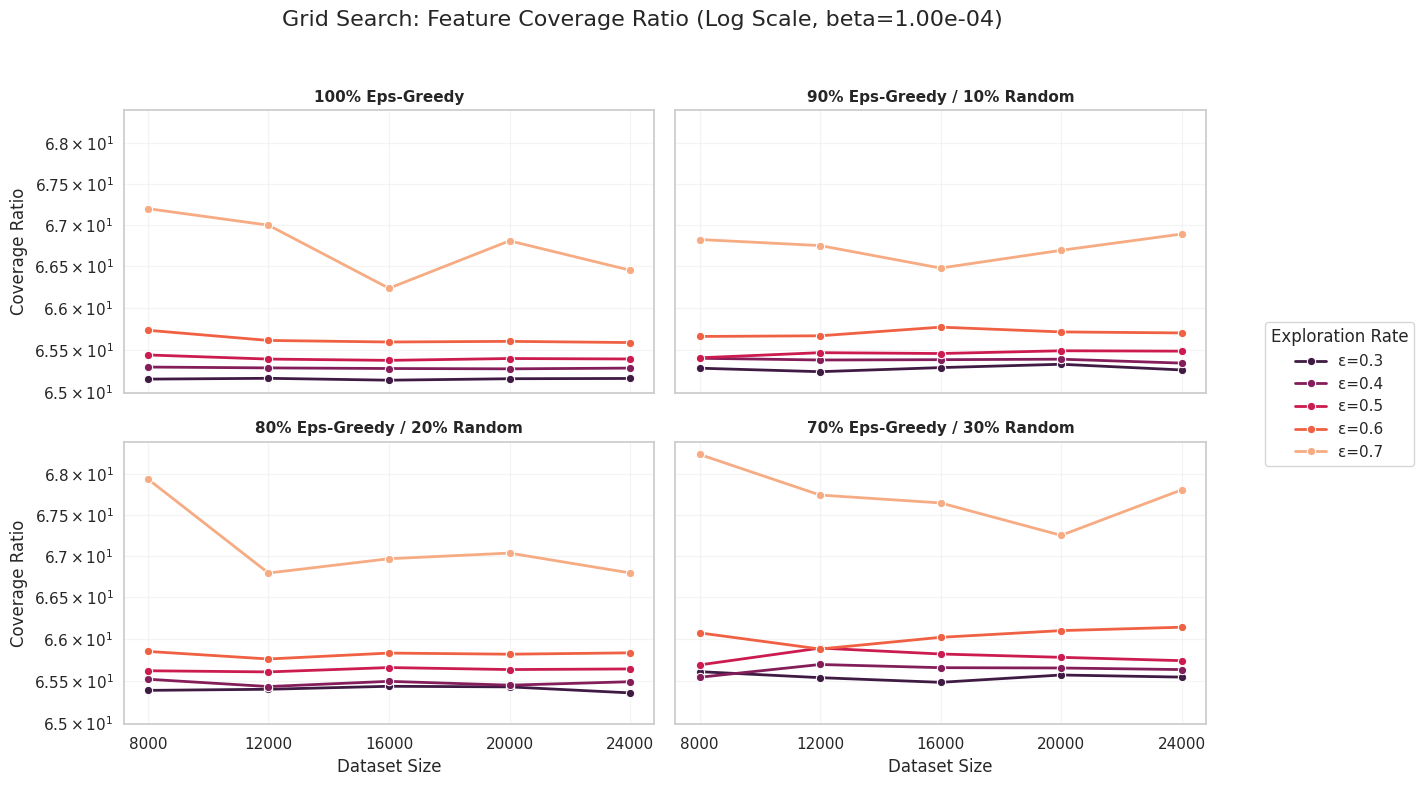


🏆 Top 5 Most Efficient Configurations (Lowest Ratio):


,Dataset Size,Epsilon,Configuration,Coverage Ratio,Log Ratio,Gap to 1.0,Epsilon_Label
2,16000,0.3,100% Eps-Greedy,65.143271,1.813870,64.143271,ε=0.3
0,8000,0.3,100% Eps-Greedy,65.155851,1.813953,64.155851,ε=0.3
3,20000,0.3,100% Eps-Greedy,65.160460,1.813984,64.160460,ε=0.3
4,24000,0.3,100% Eps-Greedy,65.163679,1.814006,64.163679,ε=0.3
1,12000,0.3,100% Eps-Greedy,65.165402,1.814017,64.165402,ε=0.3


In [ ]:
# --- 1. Configuration & Parameter Setup ---
# Vary dataset sizes around your baseline
dataset_sizes = [8000, 12000, 16000, 20000, 24000]
epsilon_values = [0.3, 0.4, 0.5, 0.6, 0.7]

# Policy proportions: [Epsilon-Greedy, Random]
proportion_configs = {
    "100/0": ([1.0, 0.0], "100% Eps-Greedy"),
    "90/10": ([0.9, 0.1], "90% Eps-Greedy / 10% Random"),
    "80/20": ([0.8, 0.2], "80% Eps-Greedy / 20% Random"),
    "70/30": ([0.7, 0.3], "70% Eps-Greedy / 30% Random"),
}

# Robust Beta Retrieval
def get_beta():
    for name in ['solver_e1', 'solver_e', 'solver']:
        if name in globals():
            obj = globals()[name]
            if hasattr(obj, 'params') and hasattr(obj.params, 'beta'):
                val = obj.params.beta
                return float(val.item()) if hasattr(val, 'item') else float(val)
    print("Warning: Beta not found. Using default 1e-4.")
    return 1e-4

beta_val = get_beta()
temp_dir = "temp_grid_search"
os.makedirs(temp_dir, exist_ok=True)

results = []
total_iters = len(dataset_sizes) * len(epsilon_values) * len(proportion_configs)

print(f"🚀 Starting Grid Search (beta={beta_val:.2e}) | {total_iters} scenarios...")

# --- 2. Grid Search Execution ---
with tqdm(total=total_iters, desc="Analyzing Coverage") as pbar:
    for label, (props, prop_name) in proportion_configs.items():
        for eps in epsilon_values:
            # We assume mdp.pi_star is available from previous cells
            epsilon_policy = (mdp.pi_star, eps)
            
            for n_steps in dataset_sizes:
                fname = f"gs_{label}_eps{eps}_n{n_steps}.csv"
                save_path = os.path.join(temp_dir, fname)
                
                # Collect
                collector.collect_mixed_dataset(
                    policies=[epsilon_policy, "random"],
                    proportions=props,
                    n_steps=n_steps,
                    episode_based=True,
                    save_path=save_path,
                    verbose=False
                )
                
                # Analyze
                try:
                    analyzer = DatasetAnalyzer(save_path)
                    ratio = analyzer.feature_coverage_ratio(
                        mdp=mdp,
                        beta=beta_val,
                        use_optimal_policy=True,
                        verbose=False
                    )
                except Exception as e:
                    ratio = np.nan
                
                results.append({
                    "Dataset Size": n_steps,
                    "Epsilon": eps,
                    "Configuration": prop_name,
                    "Coverage Ratio": ratio,
                    "Log Ratio": np.log10(ratio) if ratio > 0 else np.nan,
                    "Gap to 1.0": ratio - 1.0  # Common target for coverage ratios
                })
                
                # Cleanup immediately to save disk
                if os.path.exists(save_path):
                    os.remove(save_path)
                pbar.update(1)

# --- 3. Enhanced Visualization (Final Layout Fix) ---
if results:
    df = pd.DataFrame(results)
    
    # Make epsilon a string for a cleaner, categorical legend
    df['Epsilon_Label'] = df['Epsilon'].apply(lambda x: f"ε={x:.1f}")
    
    sns.set_theme(style="whitegrid")
    
    # Use manual subplots for 100% control over layout
    fig, axes = plt.subplots(2, 2, figsize=(13, 8), sharex=True, sharey=True)
    axes_flat = axes.flatten()
    
    configs = df['Configuration'].unique()
    palette = sns.color_palette("rocket", n_colors=len(df['Epsilon'].unique()))
    for i, config in enumerate(configs):
        ax = axes_flat[i]
        subset = df[df['Configuration'] == config]
        
        # Plot lines
        sns.lineplot(
            data=subset, 
            x="Dataset Size", 
            y="Coverage Ratio", 
            hue="Epsilon_Label", 
            palette=palette,
            marker="o", 
            linewidth=2,
            ax=ax,
            legend=(i == 1) # Put legend handles only on top-right for extraction
        )
        
        # Formatting
        ax.set_yscale('log')
        ax.set_title(config, fontweight='bold', fontsize=11)
        ax.set_xticks(dataset_sizes)
        ax.grid(True, which="both", ls="-", alpha=0.2)
        
        # Labels: Only show on the 'outer' edges
        ax.set_ylabel("Coverage Ratio" if i % 2 == 0 else "")
        ax.set_xlabel("Dataset Size" if i >= 2 else "")
    # --- Robust Legend Placement ---
    # Extract handles from the axis we assigned the legend to
    handles, labels = axes_flat[1].get_legend_handles_labels()
    axes_flat[1].get_legend().remove() # Remove it from inside the plot
    
    # Place legend on the far right of the figure
    fig.legend(handles, labels, title="Exploration Rate", loc='center right', 
               bbox_to_anchor=(1.1, 0.5), frameon=True)
    # Global Title
    fig.suptitle(f"Grid Search: Feature Coverage Ratio (Log Scale, beta={beta_val:.2e})", 
                 fontsize=16, y=0.98)
    # Spacing adjustment
    plt.tight_layout(rect=[0, 0, 0.95, 0.95]) # leave space for legend and title
    plt.show()
    # --- 4. Summary Table ---
    print("\n🏆 Top 5 Most Efficient Configurations (Lowest Ratio):")
    display(df.sort_values("Coverage Ratio").head(5))

## Linear Fitted Q-Iteration

Given an offline batch dataset $\mathcal{D}={(x_i,a_i,r_i,x_i')}_{i=1}^n$, this version of (linear) FQI does:

1. **Build targets using current Q estimate**
   $$
   y_i^{(k)} = r_i + \gamma \max_{a'} Q_{\theta_k}(x'_i, a')
   $$

2. **Fit a new Q-function to those targets** by regression on $(x_i,a_i)$
   $$
   \theta_{k+1}^{+}
   = \arg\min_\theta \sum_{i=1}^n \left(y_i^{(k)} - \phi(x_i,a_i)^\top\theta\right)^2 + \lambda|\theta|_2^2
   $$

3. (Optional) **soft update**:
   $$
   \theta_{k+1} = \tau,\theta_k + (1-\tau),\theta_{k+1}^{+}
   $$

In [22]:
# Initialize FQI Solver
solver_fqi = FQISolver(
    mdp=mdp,
    csv_path=str(DATASET_PATH),
    device=device,
    seed=seed,
    ridge=1e-2 
)
evaluator_fqi = FQIEvaluator(solver_fqi)

In [ ]:
pi_fqi = solver_fqi.run(
    K=1000, 
    tau=0.1, 
    verbose=True
)
print("\nFQI Policy:")
evaluator_fqi.print_policy()
evaluator_fqi.compare_final_rewards()
evaluator_fqi.print_optimal_path(max_steps=30)

FQI: 100%|███████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1799.91it/s, theta_norm=3.8244]


FQI Policy:

========== LEARNED POLICY (FQI) ==========
  State 0: π(a=0|s=0) = 0.00  π(a=1|s=0) = 1.00  π(a=2|s=0) = 0.00  π(a=3|s=0) = 0.00  --> best action: 1
  State 1: π(a=0|s=1) = 0.00  π(a=1|s=1) = 0.00  π(a=2|s=1) = 1.00  π(a=3|s=1) = 0.00  --> best action: 2
  State 2: π(a=0|s=2) = 0.00  π(a=1|s=2) = 0.00  π(a=2|s=2) = 0.00  π(a=3|s=2) = 1.00  --> best action: 3
  State 3: π(a=0|s=3) = 0.00  π(a=1|s=3) = 1.00  π(a=2|s=3) = 0.00  π(a=3|s=3) = 0.00  --> best action: 1
  State 4: π(a=0|s=4) = 1.00  π(a=1|s=4) = 0.00  π(a=2|s=4) = 0.00  π(a=3|s=4) = 0.00  --> best action: 0
  State 5: π(a=0|s=5) = 0.00  π(a=1|s=5) = 1.00  π(a=2|s=5) = 0.00  π(a=3|s=5) = 0.00  --> best action: 1
  State 6: π(a=0|s=6) = 0.00  π(a=1|s=6) = 1.00  π(a=2|s=6) = 0.00  π(a=3|s=6) = 0.00  --> best action: 1
  State 7: π(a=0|s=7) = 0.00  π(a=1|s=7) = 0.00  π(a=2|s=7) = 0.00  π(a=3|s=7) = 1.00  --> best action: 3
  State 8: π(a=0|s=8) = 0.00  π(a=1|s=8) = 1.00  π(a=2|s=8) = 0.00  π(a=3|s=8) = 0.00  --> best

In [32]:
walls = [4, 11, 14, 17, 21, 22, 27, 34, 37, 40, 42, 43, 44, 45, 46, 47, 49, 54, 62, 64, 66, 72, 76, 82, 84, 86, 87, 94]
pits = [18, 32, 57, 61, 75]
goal = [99]

# Configure the probabilities: 
# 80% of trajectories start in a random "safe" state
# 20% of trajectories start in the fixed initial state (x0)
reset_options = {
    'random': 0.8, 
    'x0': 0.2
}

# Initialize the collector with these options
collector = EnvDataCollector(
    mdp=mdp,
    env_name="10grid_wall",
    restricted_states=walls,  # These will never be starting states
    terminal_states=pits + goal, # Terminal states are also excluded
    reset_probs=reset_options,
    max_steps=50
)
DATASET_PATH2 = PROJECT_ROOT / "datasets" / "10grid_wall_fqi.csv"

epsilon_policy = (mdp.pi_star, 0.3)
# Use it in your mixed dataset collection
collector.collect_mixed_dataset(
    policies=[epsilon_policy, "random"],  # First policy is epsilon-greedy pi_star
    proportions=[0.7, 0.3],               # 70% epsilon-greedy, 30% fully random
    n_steps=20000,
    episode_based=True,
    save_path=str(DATASET_PATH2),
    verbose=True
)


  MIXED DATASET COLLECTION SUMMARY (TORCH)
Total transitions: 20000
Total episodes: 799
Mode: Episode-based

Policy Distribution:
  Policy 0: 13307 steps (66.5%) | Target: 70.0% | Episodes: 569
  Policy 1:  6693 steps (33.5%) | Target: 30.0% | Episodes: 231

✅ Mixed dataset saved to: /shared/home/mauro.diaz/work/FOGAS/datasets/10grid_wall_fqi.csv


,episode,step,state,action,reward,next_state,policy_id
0,0,0,3,0,-0.1,3,1
1,0,1,3,3,-0.1,3,1
2,0,2,3,2,-0.1,2,1
3,0,3,2,1,-0.1,12,1
4,0,4,12,1,-0.1,12,1
...,...,...,...,...,...,...,...
19995,799,10,8,3,-0.1,9,0
19996,799,11,9,1,-0.1,19,0
19997,799,12,19,3,-0.1,19,0
19998,799,13,19,1,-0.1,29,0


In [33]:
# Initialize FQI Solver
solver_fqi = FQISolver(
    mdp=mdp,
    csv_path=str(DATASET_PATH2),
    device=device,
    seed=seed,
    ridge=1e-2 
)
evaluator_fqi = FQIEvaluator(solver_fqi)
pi_fqi = solver_fqi.run(
    K=1000, 
    tau=0.1, 
    verbose=True
)
print("\nFQI Policy:")
evaluator_fqi.print_policy()
evaluator_fqi.compare_final_rewards()
evaluator_fqi.print_optimal_path(max_steps=30)

FQI: 100%|████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 730.41it/s, theta_norm=5.1750]



FQI Policy:

========== LEARNED POLICY (FQI) ==========
  State 0: π(a=0|s=0) = 0.00  π(a=1|s=0) = 1.00  π(a=2|s=0) = 0.00  π(a=3|s=0) = 0.00  --> best action: 1
  State 1: π(a=0|s=1) = 0.00  π(a=1|s=1) = 0.00  π(a=2|s=1) = 1.00  π(a=3|s=1) = 0.00  --> best action: 2
  State 2: π(a=0|s=2) = 0.00  π(a=1|s=2) = 0.00  π(a=2|s=2) = 0.00  π(a=3|s=2) = 1.00  --> best action: 3
  State 3: π(a=0|s=3) = 0.00  π(a=1|s=3) = 1.00  π(a=2|s=3) = 0.00  π(a=3|s=3) = 0.00  --> best action: 1
  State 4: π(a=0|s=4) = 1.00  π(a=1|s=4) = 0.00  π(a=2|s=4) = 0.00  π(a=3|s=4) = 0.00  --> best action: 0
  State 5: π(a=0|s=5) = 0.00  π(a=1|s=5) = 0.00  π(a=2|s=5) = 0.00  π(a=3|s=5) = 1.00  --> best action: 3
  State 6: π(a=0|s=6) = 0.00  π(a=1|s=6) = 0.00  π(a=2|s=6) = 0.00  π(a=3|s=6) = 1.00  --> best action: 3
  State 7: π(a=0|s=7) = 0.00  π(a=1|s=7) = 0.00  π(a=2|s=7) = 0.00  π(a=3|s=7) = 1.00  --> best action: 3
  State 8: π(a=0|s=8) = 0.00  π(a=1|s=8) = 1.00  π(a=2|s=8) = 0.00  π(a=3|s=8) = 0.00  --> best

Starting Grid Search: 144 configurations...
[1/144] N=500, eps=0.0, prop=0.8 | R=-0.1000, Succ=0.00
[2/144] N=500, eps=0.0, prop=0.5 | R=-2.9934, Succ=0.00
[3/144] N=500, eps=0.0, prop=0.2 | R=-2.9934, Succ=0.00
[4/144] N=500, eps=0.0, prop=0.1 | R=-0.1000, Succ=0.00
[5/144] N=500, eps=0.05, prop=0.8 | R=-0.1000, Succ=0.00
[6/144] N=500, eps=0.05, prop=0.5 | R=-0.1000, Succ=0.00
[7/144] N=500, eps=0.05, prop=0.2 | R=-0.1000, Succ=0.00
[8/144] N=500, eps=0.05, prop=0.1 | R=-0.1000, Succ=0.00
[9/144] N=500, eps=0.1, prop=0.8 | R=-0.1000, Succ=0.00
[10/144] N=500, eps=0.1, prop=0.5 | R=-0.1000, Succ=0.00
[11/144] N=500, eps=0.1, prop=0.2 | R=-0.1000, Succ=0.00
[12/144] N=500, eps=0.1, prop=0.1 | R=-2.9934, Succ=0.00
[13/144] N=500, eps=0.2, prop=0.8 | R=-0.1000, Succ=0.00
[14/144] N=500, eps=0.2, prop=0.5 | R=-0.1000, Succ=0.00
[15/144] N=500, eps=0.2, prop=0.2 | R=-0.1000, Succ=0.00
[16/144] N=500, eps=0.2, prop=0.1 | R=-0.1000, Succ=0.00
[17/144] N=500, eps=0.3, prop=0.8 | R=-0.1000, Su

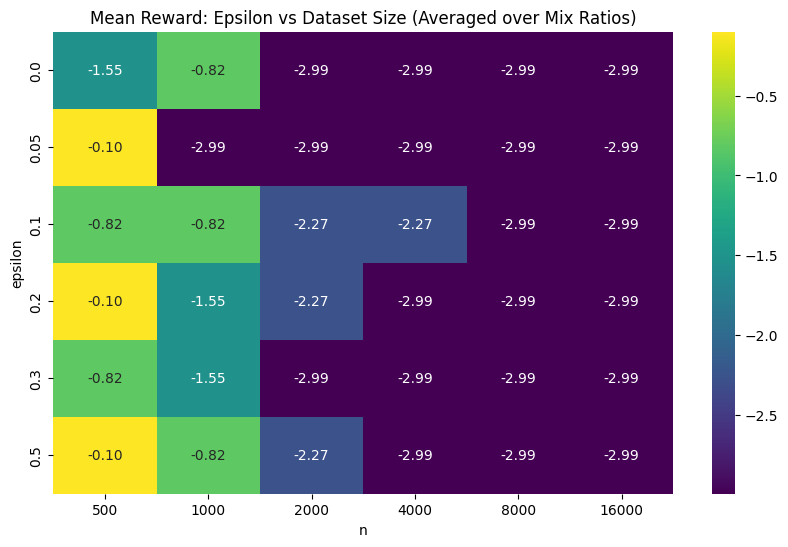

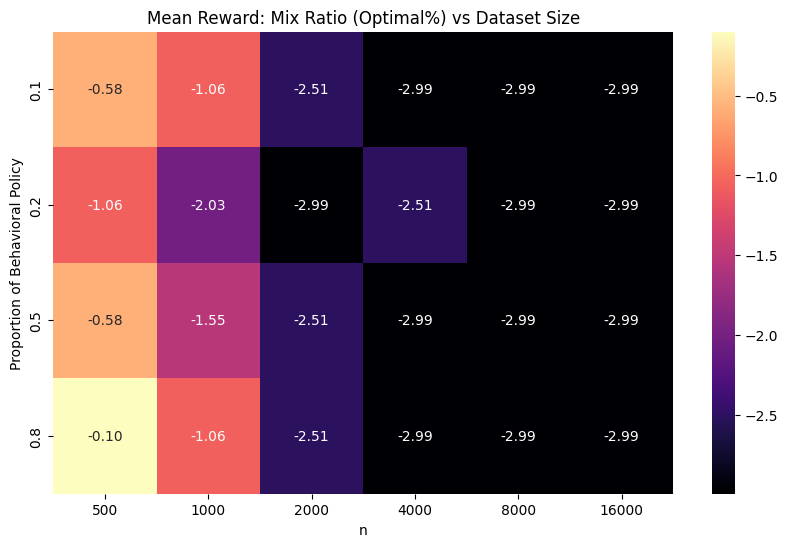

In [27]:
from fogas_torch.algorithm import run_coverage_grid_search

df_results = run_coverage_grid_search(
    mdp=mdp, 
    device=device,
    seed=seed,
    goal_state=99
)